In [1]:
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import torch
import triton
import triton.language as tl

In [99]:
@triton.jit
def fasta_kernel(
    Q_ptr, K_ptr, attn_ptr,
    B, H, N, D: tl.constexpr, BLOCK_SIZE: tl.constexpr,
    stride_qb, stride_qh, stride_q0, stride_q1,
    stride_kb, stride_kh, stride_k0, stride_k1,
    stride_attnb, stride_attnh, stride_attn0, stride_attn1,
    locality_threshold: tl.constexpr
):
    pid = tl.program_id(0)
    n_blocks = tl.cdiv(N, BLOCK_SIZE)
    b_idx = pid // (H * n_blocks * n_blocks)
    head_idx = (pid // (n_blocks * n_blocks)) % H
    block_idx = pid % (n_blocks * n_blocks)
    row_block_idx = block_idx // n_blocks
    col_block_idx = block_idx % n_blocks

    row_start = row_block_idx * BLOCK_SIZE
    col_start = col_block_idx * BLOCK_SIZE

    offs_q = row_start + tl.arange(0, BLOCK_SIZE)
    offs_k = col_start + tl.arange(0, BLOCK_SIZE)
    offs_d = tl.arange(0, D)

    acc = tl.zeros((BLOCK_SIZE, BLOCK_SIZE), dtype=tl.float32)

    q_ptrs = Q_ptr + b_idx * stride_qb + head_idx * stride_qh + offs_q[:, None] * stride_q0 + offs_d[None, :] * stride_q1
    k_ptrs = K_ptr + b_idx * stride_kb + head_idx * stride_kh + offs_k[:, None] * stride_k0 + offs_d[None, :] * stride_k1

    q_mask = offs_q[:, None] < N
    k_mask = offs_k[:, None] < N

    q_block = tl.load(q_ptrs, mask=q_mask, other=0.0)
    k_block = tl.load(k_ptrs, mask=k_mask, other=0.0)

    # Cache for the most recent diagonal block computation
    diagonal_cache = tl.zeros((BLOCK_SIZE, BLOCK_SIZE), dtype=tl.float32)
    diagonal_mean = 0.0  # Initialize as scalar
    diagonal_var = 0.0   # Initialize as scalar

    if tl.abs(row_block_idx - col_block_idx) < locality_threshold:
        block_attn = tl.dot(q_block, tl.trans(k_block))
        acc += block_attn

        # Store diagonal statistics in cache
        diagonal_mean = tl.sum(block_attn) / (BLOCK_SIZE * BLOCK_SIZE)
        diagonal_var = tl.sum((block_attn - diagonal_mean) * (block_attn - diagonal_mean)) / (BLOCK_SIZE * BLOCK_SIZE)
        diagonal_cache = block_attn
    else:
        q_mask_sum = tl.sum(q_mask)
        q_mask_sum = tl.where(q_mask_sum == 0, 1.0, q_mask_sum)
        q_summary = tl.sum(q_block, axis=0) / q_mask_sum

        k_mask_sum = tl.sum(k_mask)
        k_mask_sum = tl.where(k_mask_sum == 0, 1.0, k_mask_sum)
        k_summary = tl.sum(k_block, axis=0) / k_mask_sum

        dot_product = tl.sum(q_summary * k_summary)
        approx_attn = tl.full((BLOCK_SIZE, BLOCK_SIZE), dot_product, dtype=tl.float32)

        # Normalize and scale based on cached diagonal block statistics
        approx_attn = (approx_attn - diagonal_mean) / tl.sqrt(diagonal_var + 1e-6)

        valid_mask = q_mask & k_mask.T
        approx_attn = tl.where(valid_mask, approx_attn, 0.0)
        acc += approx_attn

    offs_attn_i = row_start + tl.arange(0, BLOCK_SIZE)
    offs_attn_j = col_start + tl.arange(0, BLOCK_SIZE)
    attn_ptrs = attn_ptr + b_idx * stride_attnb + head_idx * stride_attnh + offs_attn_i[:, None] * stride_attn0 + offs_attn_j[None, :] * stride_attn1
    mask = (offs_attn_i[:, None] < N) & (offs_attn_j[None, :] < N)
    tl.store(attn_ptrs, acc, mask=mask)


def fasta_attn(Q, K, block_size, locality_threshold=2):
    """
    Computes FASTA attention using Triton with optimized intra-block matmul and Gaussian-like spread.

    Args:
        Q (torch.Tensor): Query tensor of shape (B, H, N, D)
        K (torch.Tensor): Key tensor of shape (B, H, N, D)
        block_size (int): Size of attention blocks
        locality_threshold (int): Threshold for locality comparison

    Returns:
        torch.Tensor: Attention weights of shape (B, H, N, N)
    """
    B, H, N, D = Q.shape

    Q = Q.contiguous()
    K = K.contiguous()

    attn = torch.empty((B, H, N, N), device=Q.device, dtype=Q.dtype)

    n_blocks = triton.cdiv(N, block_size)
    grid = (B * H * n_blocks * n_blocks,)

    fasta_kernel[grid](
        Q, K, attn,
        B, H, N, D, block_size,
        Q.stride(0), Q.stride(1), Q.stride(2), Q.stride(3),
        K.stride(0), K.stride(1), K.stride(2), K.stride(3),
        attn.stride(0), attn.stride(1), attn.stride(2), attn.stride(3),
        locality_threshold
    )

    return attn

In [100]:
def test_fasta_attention_benchmark(N, D, block_size, num_iterations, locality_threshold=2):
    """
    Benchmark function for optimized FASTA attention implementation
    and standard self-attention. Includes batching for efficiency.
    """

    device = 'cuda'

    assert torch.cuda.is_available(), "CUDA is not available. Please run on a CUDA-enabled device."

    torch.manual_seed(0)
    Q = torch.randn(N, D, device=device, dtype=torch.float32)
    K = torch.randn(N, D, device=device, dtype=torch.float32)

    Q_fasta = Q.unsqueeze(0).unsqueeze(0)
    K_fasta = K.unsqueeze(0).unsqueeze(0)

    print("Computing standard self-attention for all iterations...")
    standard_times = []
    standard_outputs = []

    for idx in tqdm(range(num_iterations), desc="Standard Self-Attention"):
        start_std = torch.cuda.Event(enable_timing=True)
        end_std = torch.cuda.Event(enable_timing=True)

        start_std.record()
        attn_ref = Q @ K.T
        end_std.record()

        torch.cuda.synchronize()
        elapsed_std = start_std.elapsed_time(end_std)
        standard_times.append(elapsed_std)
        if idx % 1000 == 0:
            standard_outputs.append(attn_ref.detach().cpu().numpy())

    print("Computing optimized FASTA attention for all iterations...")
    fasta_times = []
    fasta_outputs = []

    for idx in tqdm(range(num_iterations), desc="FASTA Attention"):
        start_fasta = torch.cuda.Event(enable_timing=True)
        end_fasta = torch.cuda.Event(enable_timing=True)

        start_fasta.record()
        attn_fasta = fasta_attn(Q_fasta, K_fasta, block_size=block_size, locality_threshold=locality_threshold).squeeze(0).squeeze(0)
        end_fasta.record()

        torch.cuda.synchronize()
        elapsed_fasta = start_fasta.elapsed_time(end_fasta)
        fasta_times.append(elapsed_fasta)
        if idx % 1000 == 0:
            fasta_outputs.append(attn_fasta.detach().cpu().numpy())

    standard_times = np.array(standard_times)
    fasta_times = np.array(fasta_times)

    print("Computing error metrics...")
    mae_list = []
    max_error_list = []
    relative_error_list = []

    for ref, fasta in zip(standard_outputs, fasta_outputs):
        abs_diff = np.abs(ref - fasta)
        mae_list.append(abs_diff.mean().item())
        max_error_list.append(abs_diff.max().item())
        relative_error_list.append((abs_diff / np.abs(ref + 1e-6)).mean().item())

    print("Benchmarking completed!")
    print("\nTiming Statistics:")
    print(f"Standard Self-Attention - Mean: {standard_times.mean():.4f} ms, Std: {standard_times.std():.4f} ms")
    print(f"FASTA Attention - Mean: {fasta_times.mean():.4f} ms, Std: {fasta_times.std():.4f} ms")
    print(f"Percentage Improvement: {100 * (1 - fasta_times.mean() / standard_times.mean()):.2f}%")

    print("\nError Metrics (Average over all iterations):")
    print(f"Mean Absolute Error (MAE): {np.mean(mae_list):.6f}")
    print(f"Maximum Absolute Error: {np.mean(max_error_list):.6f}")
    print(f"Relative Error: {np.mean(relative_error_list):.6f}")

    plt.figure(figsize=(12, 6))
    sns.histplot(fasta_times, color='blue', label='FASTA Attention', kde=True, stat="density", bins=50, alpha=0.6)
    sns.histplot(standard_times, color='orange', label='Standard Attention', kde=True, stat="density", bins=50, alpha=0.6)
    plt.title('Timing Distributions')
    plt.xlabel('Time (ms)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    return standard_outputs, fasta_outputs

In [87]:
N = 2048
D = 64
block_size = 64
num_iter = 1000
locality_threshold = 2

Computing standard self-attention for all iterations...


Standard Self-Attention: 100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 7172.91it/s]


Computing optimized FASTA attention for all iterations...


FASTA Attention: 100%|█████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8097.00it/s]


Computing error metrics...
Benchmarking completed!

Timing Statistics:
Standard Self-Attention - Mean: 0.1101 ms, Std: 0.0226 ms
FASTA Attention - Mean: 0.0962 ms, Std: 0.0972 ms
Percentage Improvement: 12.60%

Error Metrics (Average over all iterations):
Mean Absolute Error (MAE): 363248.312500
Maximum Absolute Error: 1781575.875000
Relative Error: 857050.062500


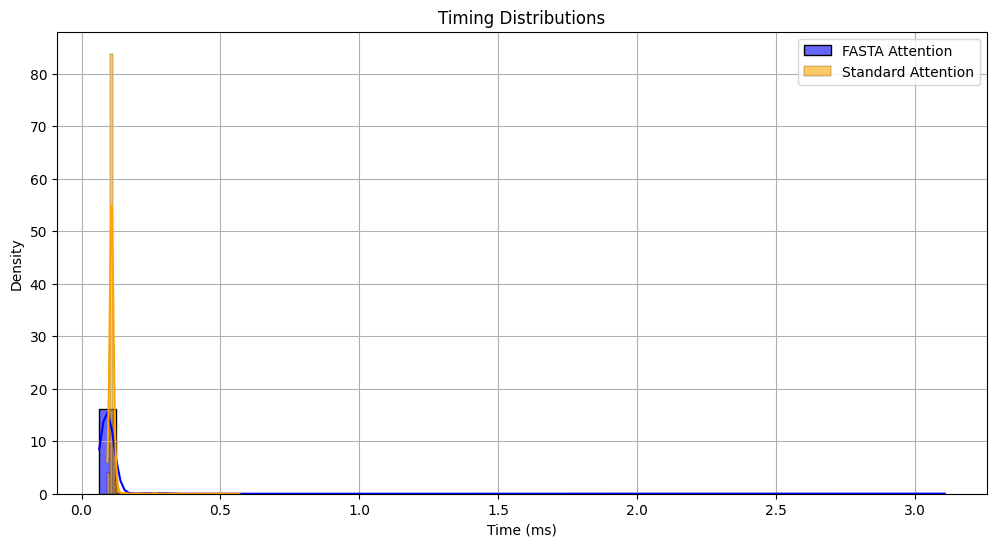

In [88]:
standard_outputs, fasta_outputs = test_fasta_attention_benchmark(N,D,block_size,num_iter,locality_threshold)

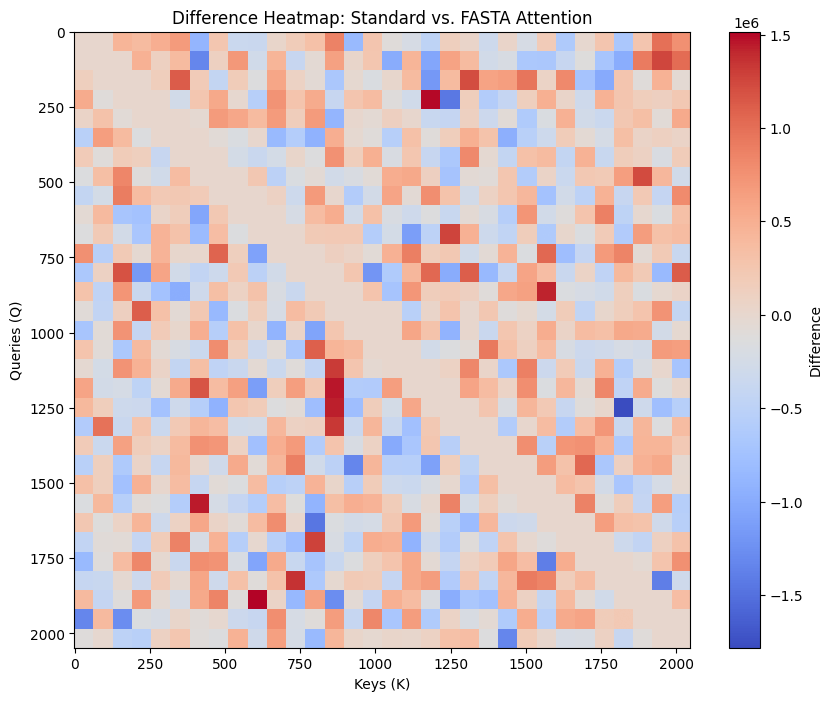

In [89]:
difference = (standard_outputs[0] - fasta_outputs[0])
# Create the heatmap for the first head
plt.figure(figsize=(10, 8))
plt.imshow(difference.squeeze(), cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Difference")
plt.title("Difference Heatmap: Standard vs. FASTA Attention")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")
plt.show()

In [90]:
matrix = standard_outputs[0] / fasta_outputs[0]  # The ratio matrix

# Get the number of grids in each dimension
num_grids_x = matrix.shape[1] // block_size
num_grids_y = matrix.shape[0] // block_size

# Initialize variables to track max ratio and its grid position
max_ratio = -np.inf
max_grid = (0, 0)

# Iterate over grids
for i in range(num_grids_y):
    for j in range(num_grids_x):
        # Extract the current grid
        grid = matrix[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
        
        # Compute the maximum ratio in the grid
        grid_max = np.max(grid)
        
        
        # Update max_ratio and max_grid if this grid has a higher max
        if grid_max > max_ratio:
            max_ratio = grid_max
            max_grid = (i, j)

# Output the result
print(f"Maximum ratio is {max_ratio} in grid (row, col): {max_grid}")

Maximum ratio is 39.47770309448242 in grid (row, col): (13, 13)


In [91]:
fasta_outputs[0]

array([[-1.5396192e+00,  1.1966492e+01,  4.5577226e+00, ...,
        -7.6112050e+05, -7.6112050e+05, -7.6112050e+05],
       [ 7.5964947e+00,  1.2790917e+01, -4.3588266e+00, ...,
        -7.6112050e+05, -7.6112050e+05, -7.6112050e+05],
       [ 2.6012356e+00, -1.0823669e+00,  4.2379475e+00, ...,
        -7.6112050e+05, -7.6112050e+05, -7.6112050e+05],
       ...,
       [ 1.1178691e+05,  1.1178691e+05,  1.1178691e+05, ...,
        -3.1956742e+00,  5.8752127e+00, -5.2315040e+00],
       [ 1.1178691e+05,  1.1178691e+05,  1.1178691e+05, ...,
         4.5822781e-01, -6.7046294e+00,  6.6593528e-01],
       [ 1.1178691e+05,  1.1178691e+05,  1.1178691e+05, ...,
         2.0555376e+01,  1.1820204e+00,  7.7578316e+00]], dtype=float32)

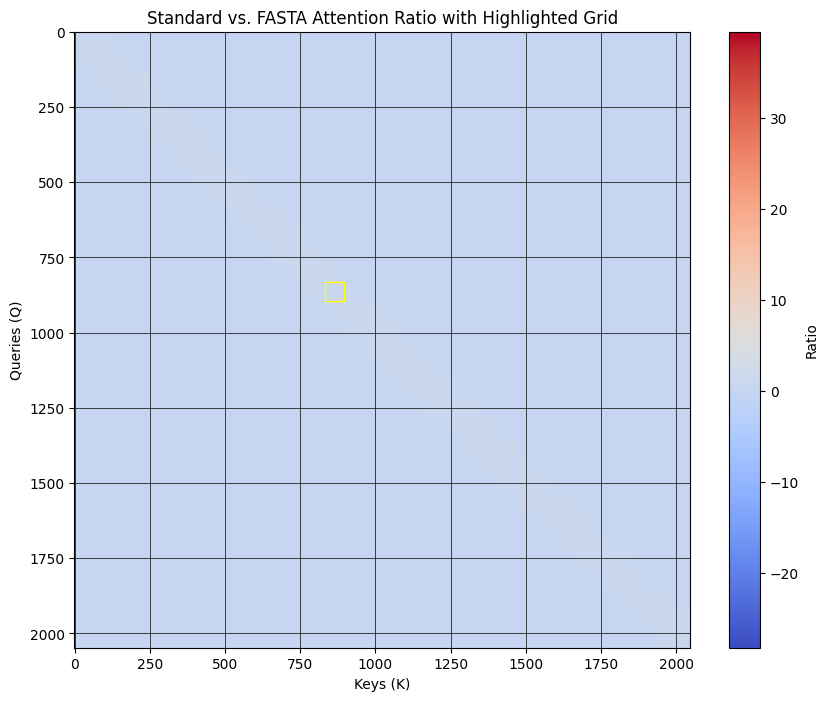

In [92]:
# Highlight the grid
plt.figure(figsize=(10, 8))
plt.imshow(standard_outputs[0] / fasta_outputs[0], cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Ratio")
plt.title("Standard vs. FASTA Attention Ratio with Highlighted Grid")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")

# Add grid lines
plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)

# Highlight the grid
rect_x = max_grid[1] * block_size
rect_y = max_grid[0] * block_size
rect = plt.Rectangle((rect_x, rect_y), block_size, block_size, edgecolor='yellow', facecolor='none', lw=1)
plt.gca().add_patch(rect)

plt.show()

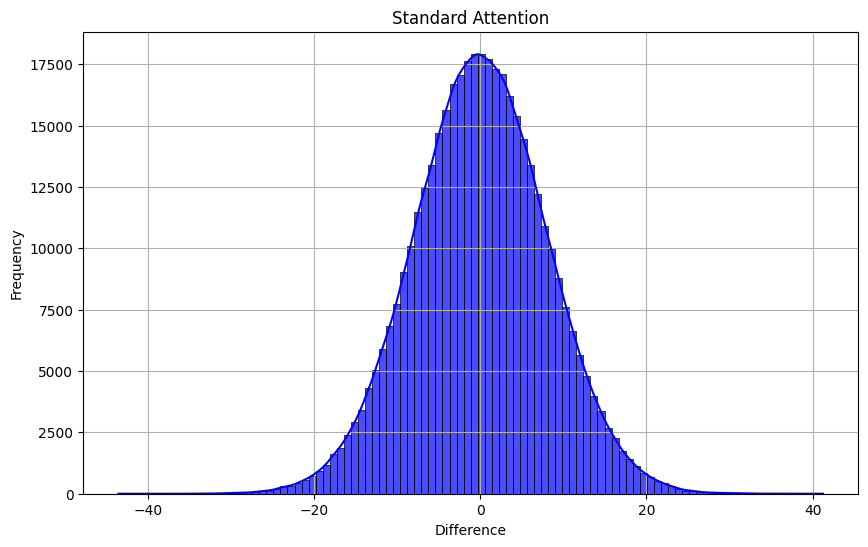

In [93]:
# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(standard_outputs[0].flatten()[::10], bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Standard Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


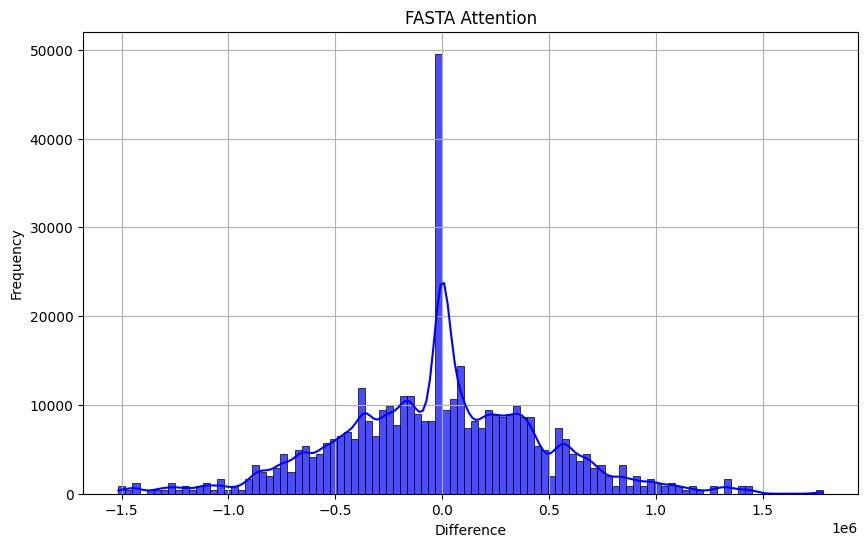

In [94]:
plt.figure(figsize=(10, 6))
sns.histplot(fasta_outputs[0].flatten()[::10], bins=100, kde=True, color='blue', alpha=0.7)
plt.title("FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

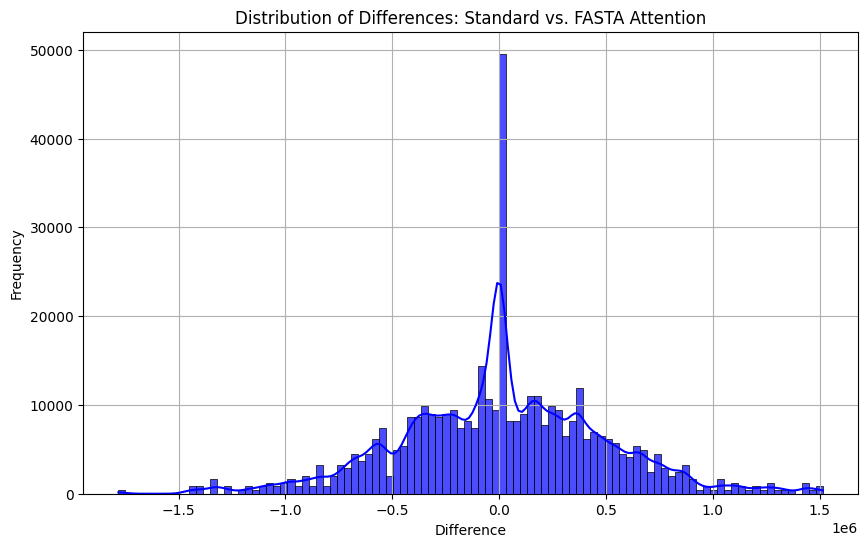

In [95]:
subsampled_difference = difference.flatten()[::10]  # Take every 10th value

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(subsampled_difference, bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Differences: Standard vs. FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

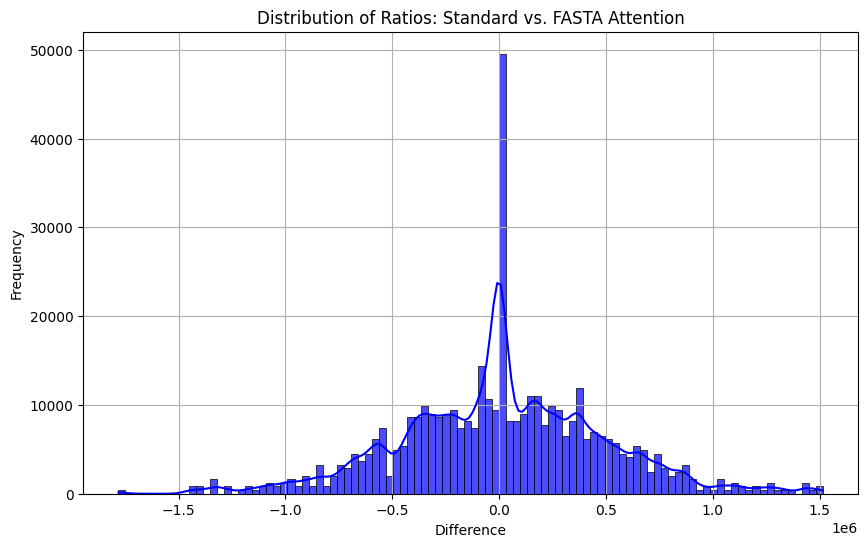

In [96]:
subsampled_ratio = (standard_outputs[0] / fasta_outputs[0]).flatten()[::10]  # Take every 10th value

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(subsampled_difference, bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Ratios: Standard vs. FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [97]:
row_block_idx,col_block_idx = max_grid

# Compute Q indices
q_start = row_block_idx * block_size
q_end = (row_block_idx + 1) * block_size - 1

# Compute K indices
k_start = col_block_idx * block_size
k_end = (col_block_idx + 1) * block_size - 1

print(f"Q indices for block (row=6): {q_start} to {q_end}")
print(f"K indices for block (col=4): {k_start} to {k_end}")

Q indices for block (row=6): 832 to 895
K indices for block (col=4): 832 to 895


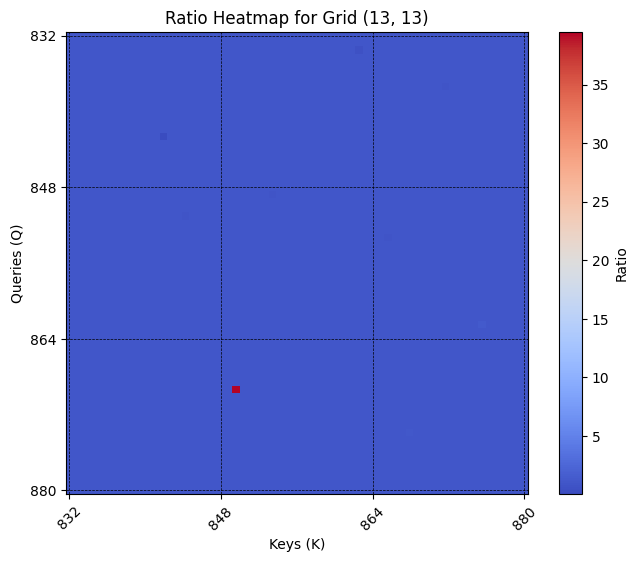

In [98]:
# Compute indices for the highlighted grid
q_start = max_grid[0] * block_size
q_end = (max_grid[0] + 1) * block_size
k_start = max_grid[1] * block_size
k_end = (max_grid[1] + 1) * block_size

# Extract the submatrix for the highlighted grid
highlighted_block = (standard_outputs[0] / fasta_outputs[0])[q_start:q_end, k_start:k_end]

# Generate x and y tick labels for indices
q_indices = np.arange(q_start, q_end, block_size // 4)  # Adjust granularity as needed
k_indices = np.arange(k_start, k_end, block_size // 4)

# Plot the heatmap for the highlighted block
plt.figure(figsize=(8, 6))
im = plt.imshow(highlighted_block, cmap='coolwarm', interpolation='nearest')
plt.colorbar(im, label="Ratio")
plt.title(f"Ratio Heatmap for Grid ({max_grid[0]}, {max_grid[1]})")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")

# Set custom ticks for better index clarity
plt.xticks(ticks=np.linspace(0, block_size - 1, len(k_indices)), labels=k_indices, rotation=45)
plt.yticks(ticks=np.linspace(0, block_size - 1, len(q_indices)), labels=q_indices)

# Add grid lines for each block cell
plt.grid(True, which='both', linestyle='--', color='black', linewidth=0.5)

plt.show()